In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import os
import json
from typing import Tuple
from tqdm import tqdm
from model_analysis.model_utils import *
from regression.regression_utils import get_train_test
sns.set(rc={"figure.figsize": (20, 10)})


In [2]:
PATH_TO_DATA = "analysis/data/"
paredoes_df = {
    "paredao": [],
    "eliminado": [],
    "rejeicao": [],
    "modelo": [],
    "pred": [],
    "pred_pct": [],
}

In [3]:

def df_to_train_data(df: pd.DataFrame) -> Tuple[np.array, np.array]:
    return df.drop(columns=["paredao", "nome", "rejeicao"], axis=1).to_numpy(), df.drop(columns=df.columns[:-1], axis=1)

def run_paredoes() -> pd.DataFrame:
    # Treinando em n-1 paredões para predizer o n-ésimo
    paredoes = len(os.listdir(PATH_TO_DATA))

    for model in tqdm(MODELS.keys(), desc="- Modelos analisados"):
        
        params = PARAMETERS[model]
        regressor_model = MODELS[model]

        for paredao in range(1, paredoes+1):
            regressor = regressor_model(**params)
            if NORMALIZE[model]:
                train_df, test_df, mean, std = get_train_test(paredao, normalize=True, drop_columns=REMOVE, data_path=PATH_TO_DATA)
            else:
                train_df, test_df = get_train_test(paredao, normalize=False, drop_columns=REMOVE,  data_path=PATH_TO_DATA)

            x_train, y_train = df_to_train_data(train_df)
            x_test, y_test = df_to_train_data(test_df)

            y_train, y_test = np.ravel(y_train), np.ravel(y_test)

            regressor.fit(x_train, y_train)
            prediction = regressor.predict(x_test)

            if NORMALIZE[model]:
                test_df["predicao"] = prediction * std + mean
                test_df["rejeicao"] =  test_df["rejeicao"] * std + mean
            else:
                test_df["predicao"] = prediction
            
            pred_elimination, pred_pct = test_df.sort_values(by="predicao", ascending=False)[["nome", "predicao"]].iloc[0] 
            true_elimination, true_pct = test_df.sort_values(by="rejeicao", ascending=False)[["nome", "rejeicao"]].iloc[0]

            paredoes_df["paredao"].append(paredao)
            paredoes_df["eliminado"].append(true_elimination)
            paredoes_df["rejeicao"].append(true_pct)
            paredoes_df["modelo"].append(model)
            paredoes_df["pred"].append(pred_elimination)
            paredoes_df["pred_pct"].append(pred_pct)
    
    return pd.DataFrame(paredoes_df)


In [4]:
paredoes_df = run_paredoes()

- Modelos analisados: 100%|██████████| 8/8 [00:21<00:00,  2.67s/it]


In [5]:
paredoes_df.head()

,paredao,eliminado,rejeicao,modelo,pred,pred_pct
0,1,lucas_chumbo,0.7594,linear_regression,lucas_chumbo,0.860978
1,2,petrix,0.8027,linear_regression,petrix,0.794741
2,3,hadson,0.7971,linear_regression,hadson,0.722763
3,4,lucas,0.6262,linear_regression,lucas,0.459758
4,5,bianca_andrade,0.5309,linear_regression,bianca_andrade,0.449258


# Contagem de acertos

In [6]:
paredoes_df["erro_absoluto"] = abs(paredoes_df["rejeicao"] - paredoes_df["pred_pct"])
paredoes_df["acertos"] = paredoes_df["eliminado"] == paredoes_df["pred"]

In [7]:
resultados_por_modelo = paredoes_df[["modelo", "acertos"]].groupby("modelo").sum()

In [8]:
resultados_por_modelo

,acertos
modelo,
ada_boost,10.0
elastic_net,11.0
knn,9.0
lasso,11.0
linear_regression,11.0
random_forest,10.0
ridge,11.0
svm,11.0


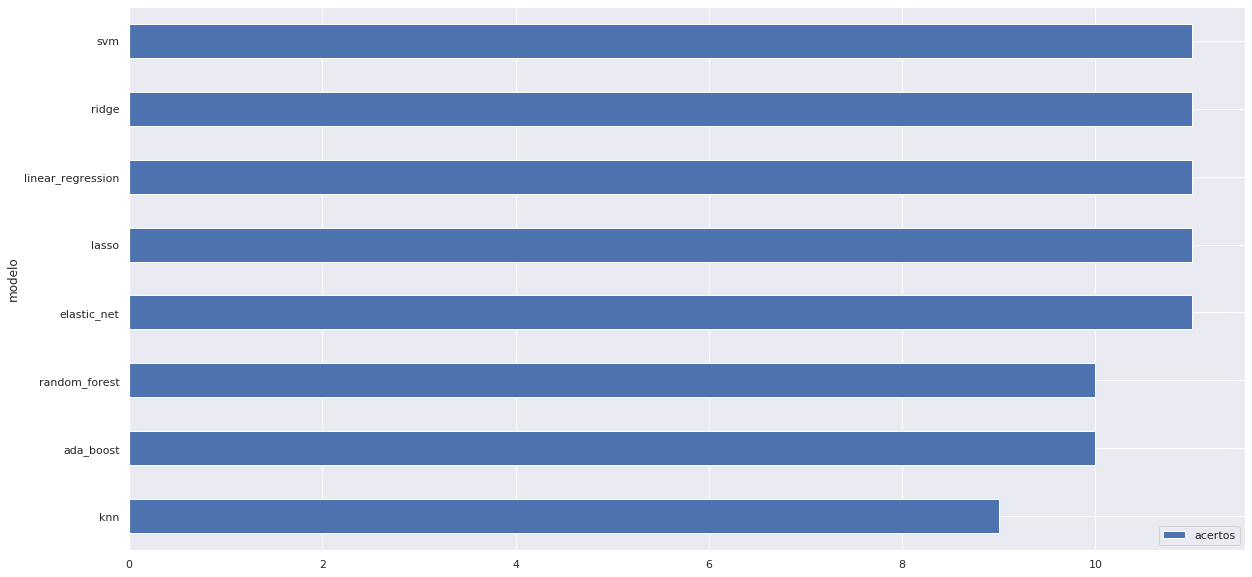

In [9]:
resultados_por_modelo.sort_values(by="acertos").plot.barh()

# Análise de erro absoluto por paredão

In [10]:
paredoes_df.sort_values(by="paredao", inplace=True)
erro_df = paredoes_df.set_index("paredao").pivot(columns="modelo")

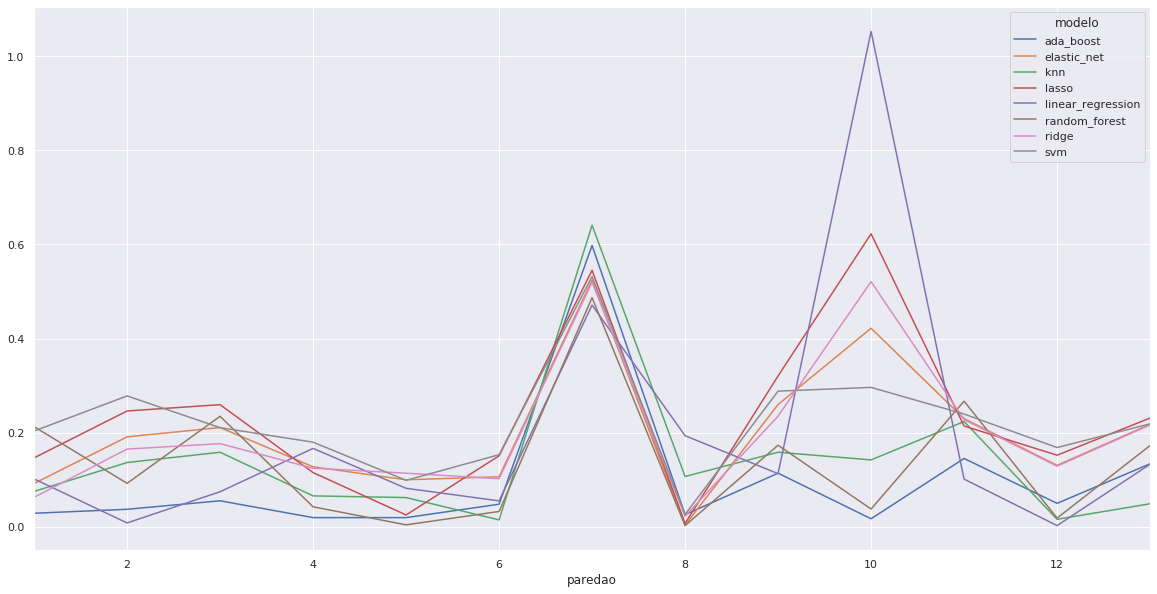

In [11]:
erro_df["erro_absoluto"].plot()

# Acertos em cada paredão

In [12]:
erro_df["acertos"] = erro_df["acertos"].astype(int)

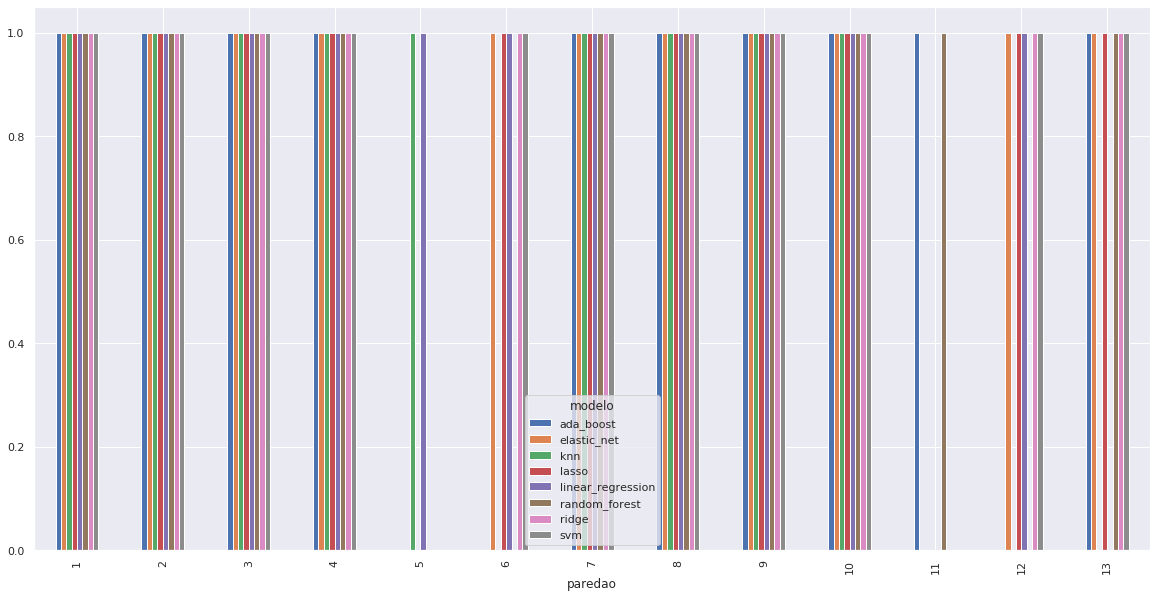

In [13]:
erro_df["acertos"].plot.bar()